<a href="https://colab.research.google.com/github/kathmandu777/Img-and-Video-check/blob/main/GenTwo_imgcheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GenTwoの投稿画像検証
- GenTwoにおいて、投稿された画像が不適切かどうかを判断します。

<br>  
***

### 設計
1. 投稿画像の受け取り
2. 画像認識
  - YOLO（性能と速度によっては変更）
  - 現在はSSDを使用
3. 認識物がNGリストに載っていればリジェクト
  - 何がリジェクトされたか、ユーザーが分かるようにバウンディングボックスの描画
4. [ ユーザーが不快画像として報告した画像から、モデルを再構築（転移学習を利用）]

### 検出オブジェクトNGリスト
- undefined

<br>  
***

## 知識
#### 物体検出について
- 物体検出(object detection)=クラス(カテゴリー)と一緒に物体の位置を予測すること
- 矩形（バウンディングボックス）= 物体の位置情報を示した図形


#### 物体検出のアルゴリズム
- Faster R-CNN : CNNを利用した物体検出の先駆けであるR-CNNを高速化したモデル。従来のR-CNNは候補領域の抽出・特徴量の計算・物体クラス分類をそれぞれ別個の処理として行っていたため高速な物体検出の処理が困難であった。このモデルではこれらの処理を1つの畳み込みCNNにまとめることで高速な物体検出の処理を実現している。

- Mask R-CNN : Faster R-CNNの改良モデル。通常の物体検出のように物体の位置を矩形領域ではなく物体の輪郭に沿った形で推定するセグメンテーションも同時に行うマルチタスク学習に分類される。輪郭に沿った形で物体を検出できるため人間の手や足の関節の位置を推定して骨格に相当する情報を抽出する姿勢推定への応用が可能。

- YOLO : You Only Look Onceの略で「見るのは一度だけ」という意味。従来の手法では候補領域の抽出の際に入力画像をスキャンしていたため入力画像を何度も見る必要があった。YOLOは入力画像をグリッドに分割してからそれぞれのグリッドに物体がふくまれている確率を推定する回帰問題として物体検出を定式化することにより、入力画像を1回だけ見れば物体検出ができるようになっている。これにより、Faster R-CNNと同様に1つの畳み込みCNNでモデルを構成することができるようになり高速な処理が可能となった。

- SSD : Single Shot MultiBox Detector の略。2016年に提案されたモデル。画像に8732個のデフォルトボックスを敷き詰め、デフォルトボックスごとに位置推定とクラス分類を実行する。ボックスと物体の位置の差分を計算する方法により、ネットワーク処理がシンプルになり大幅に速度が向上。リアルタイムでの物体検出を実現している。


### 参考文献
- [markdown記法](https://qiita.com/tbpgr/items/989c6badefff69377da7#%E5%BC%95%E7%94%A8)
- [TensorHubについて](https://kamujun.hatenablog.com/entry/2018/08/10/183201)
- [colabでのTensorFlow Hub使用方法](https://qiita.com/code0327/items/3b23fd5002b373dc8ae8)
- [TensorHubの物体検出学習済みモデル](https://tfhub.dev/s?module-type=image-object-detection)
- [物体検出について](https://qiita.com/mshinoda88/items/9770ee671ea27f2c81a9)
- [機械学習における正解率の各指標まとめ](https://qiita.com/cv_carnavi/items/08e11426e2fac8433fed)

In [1]:
# 環境変数を追加
# 検出器のモジュールを格納するフォルダの設定
import os
os.environ['TFHUB_CACHE_DIR'] ='/content/tfhub'

# 環境変数の確認
!printenv TFHUB_CACHE_DIR

# TensorFlow2.xに切り替え
%tensorflow_version 2.x

/content/tfhub


In [7]:
# 検出器のロード
import tensorflow as tf
import tensorflow_hub as hub

print("loading model")


"""
wildspeed.jpgで実験

https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1 = 45.637sec 精度はまあ良い
https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1 = 0.262sec 余分なところも反応している
https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1 = 71.238sec 精度は素晴らしい
https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1 = 6.89sec
"""

"""
object detection sample image(14images) で比較

https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1 = 0.3sec以下。精度はいまいち。
https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1 = 30sec.精度は非常に良い。
https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1 = 1sec.精度もそこまでよくない。
"""

# tensorHubにある好きなモデルを指定
module_handle = "https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1"

# tensorflow製かどうか
isTensorFlow = "tensorflow" in module_handle

#tensorflow製の時
if(isTensorFlow):
  detector = hub.load(module_handle)
else:
  detector = hub.load(module_handle).signatures['default']

print("load end")

loading model
load end


In [8]:
# COCO2017のclass_id <==> class_name の変換辞書作成
if(isTensorFlow):
  !wget https://raw.githubusercontent.com/nightrome/cocostuff/master/labels.txt

  id_to_name_dic={}
  with open("labels.txt",mode="r") as f:
    for line in f:
      i,name=line.split(":")
      id_to_name_dic[i]=str(name.replace('\n', ''))

--2021-02-22 14:52:52--  https://raw.githubusercontent.com/nightrome/cocostuff/master/labels.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2287 (2.2K) [text/plain]
Saving to: ‘labels.txt.1’

labels.txt.1        100%[===================>]   2.23K  --.-KB/s    in 0s      

2021-02-22 14:52:52 (32.5 MB/s) - ‘labels.txt.1’ saved [2287/2287]



In [9]:
# 検出結果を画像にオーバーレイ表示する関数定義
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe 

def showImage(img, r, min_score=0.1):
  fig = plt.figure(dpi=150,figsize=(4,4))
  ax = plt.gca()
  ax.tick_params(axis='both', which='both', left=False, 
                 labelleft=False, bottom=False, labelbottom=False)
  ax.imshow(img)

  decode = np.frompyfunc( lambda p : p.decode("ascii"), 1, 1)

  boxes =       r['detection_boxes']
  scores =      r['detection_scores']
  class_names = r['detection_classes'] if isTensorFlow else decode( r['detection_class_entities'])

  if isTensorFlow:
    boxes=boxes[0]
    class_names=class_names[0]
    scores=scores[0]

  n = np.count_nonzero(scores >= min_score)

  # class_names に対応した 色の準備
  class_set = np.unique(class_names[:n])
  colors = dict()
  cmap = plt.get_cmap('tab10')
  for i, v in enumerate(class_set):
    colors[v] =cmap(i)

  # 矩形を描画 スコアが低いものから描画
  img_w = img.shape[1]
  img_h = img.shape[0]
  for i in reversed(range(n)):
    if(isTensorFlow):
      class_name=id_to_name_dic[str(int(class_names[i]))]
      score=float(scores[i])
    else:
      class_name=class_names[i]
      score=scores[i]

    text = f'{class_name} {100*score:.0f}%'
    color = colors[class_names[i]]
    y1, x1, y2, x2 = tuple(boxes[i])
    y1, y2 = y1*img_h, y2*img_h
    x1, x2 = x1*img_w, x2*img_w

    # 枠
    r = plt.Rectangle(xy=(x1, y1), width=(x2-x1), height=(y2-y1),
                      fill=False, edgecolor=color, joinstyle='round', 
                      clip_on=False, zorder=8+(n-i) )
    ax.add_patch( r )

    # タグ：テキスト
    t = ax.text(x1+img_w/200, y1-img_h/300, text, va='bottom', fontsize=6, color=color,zorder=8+(n-i))
    t.set_path_effects([pe.Stroke(linewidth=1.5,foreground='white'), pe.Normal()])
    fig.canvas.draw()
    r = fig.canvas.get_renderer()
    coords = ax.transData.inverted().transform(t.get_window_extent(renderer=r))
    tag_w = abs(coords[0,0]-coords[1,0])+img_w/100
    tag_h = abs(coords[0,1]-coords[1,1])+img_h/120

    # タグ：背景
    r = plt.Rectangle(xy=(x1, y1-tag_h), width=tag_w, height=tag_h,
                      edgecolor=color, facecolor=color,
                      joinstyle='round', clip_on=False, zorder=8+(n-i))
    ax.add_patch(r)
  plt.show()


In [10]:
# 物体検出を実行する関数定義
import time
import numpy as np
import PIL.Image as Image

def run_detector(detector, path):

  # 画像を読み込んで detector に入力できる形式に変換
  img = Image.open(path) # Pillow(PIL)
  if img.mode == 'RGBA' :
    img = img.convert('RGB')
  
  converted_img = img.copy()
  converted_img = converted_img.resize((227,227),Image.LANCZOS) # 入力サイズに縮小
  converted_img = np.array(converted_img, dtype=np.float32)     # np.arrayに変換
  if(not isTensorFlow):
    converted_img = converted_img / 255. # 0.0 ～ 1.0 に正規化
  converted_img = converted_img.reshape([1,227,227,3])
  converted_img = tf.constant(converted_img)
  
  if(isTensorFlow):
    converted_img = tf.cast(converted_img, dtype=tf.uint8)

  t1 = time.time()
  result = detector(converted_img) # 一般物体検出（本体）
  t2 = time.time()
  print()
  print(f'検出時間 : {t2-t1:.3f} 秒' )
  # 結果をテキスト出力するための準備
  r = {key:value.numpy() for key,value in result.items()}
  boxes =       r['detection_boxes']
  scores =      r['detection_scores']
  decode = np.frompyfunc( lambda p : p.decode('ascii'), 1, 1)
  class_names = r['detection_classes'] if isTensorFlow else decode( r['detection_class_entities'])

  if isTensorFlow:
    boxes=boxes[0]
    class_names=class_names[0]
    scores=scores[0]

  # スコアが 0.25 以上の結果（n件）についてテキスト出力  閾値はデプロイ時に最適化する
  print(f'検出オブジェクト' )
  n = np.count_nonzero(scores >= 0.25 )
  for i in range(n):
    y1, x1, y2, x2 = tuple(boxes[i])
    x1, x2 = int(x1*img.width), int(x2*img.width)
    y1, y2 = int(y1*img.height),int(y2*img.height)

    if(isTensorFlow):
      class_name=id_to_name_dic[str(int(class_names[i]))]
      score=float(scores[i])
    else:
      class_name=class_names[i]
      score=scores[i]

    t = f'{class_name:10} {100*score:3.0f}%  '
    t += f'({x1:>4},{y1:>4}) - ({x2:>4},{y2:>4})'
    print(t)

  showImage(np.array(img), r, min_score=0.25) # 検出結果を画像にオーバーレイ(上で定義した関数)


物体検出したい画像を選択してください(複数選択可)


Saving building.jpg to building (1).jpg
Saving car.jpg to car (1).jpg
Saving car2.jpg to car2 (1).jpg
Saving donuts.jpg to donuts (1).jpg
Saving fox.jpg to fox (1).jpg
Saving gorilla.jpg to gorilla (1).jpg
Saving Hamburger.jpg to Hamburger (1).jpg
Saving man.jpg to man (1).jpg
Saving man2.jpg to man2 (1).jpg
Saving man3.jpg to man3 (1).jpg
Saving peach.jpg to peach (1).jpg
Saving pizza.jpg to pizza (1).jpg
Saving poop.jpg to poop (1).jpg
Saving woman.jpg to woman (1).jpg

検出時間 : 9.572 秒
検出オブジェクト
 tv         33%  (  22, 108) - (  54, 146)


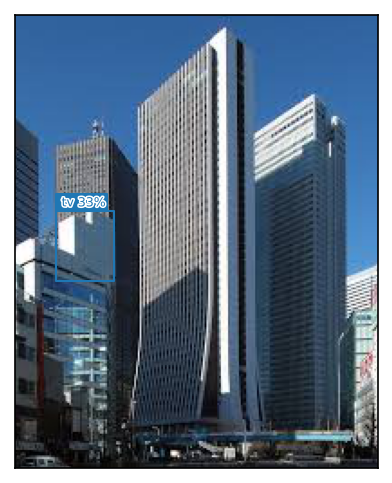


検出時間 : 3.876 秒
検出オブジェクト
 car        99%  (  31,  57) - ( 225, 153)


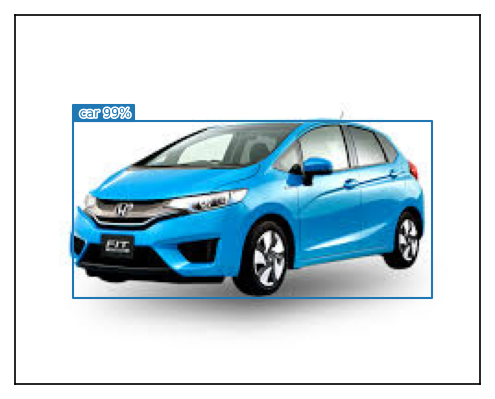


検出時間 : 3.863 秒
検出オブジェクト
 car        97%  (   0,  13) - ( 312, 152)
 truck      69%  (   0,  11) - ( 314, 130)


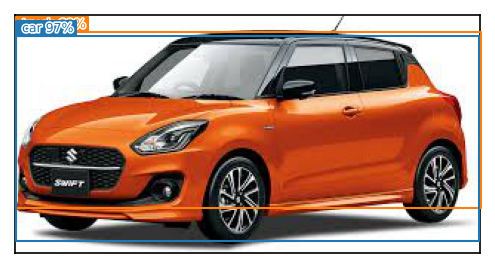


検出時間 : 3.771 秒
検出オブジェクト
 donut      96%  (  89,  63) - ( 144, 106)
 sandwich   74%  (  19, 110) - (  89, 141)
 sandwich   73%  ( 145,  50) - ( 215, 100)
 sandwich   71%  (  12,  93) - (  92, 143)
 sandwich   68%  (  14,  91) - (  90, 120)
 donut      55%  (  89, 133) - ( 148, 144)
 donut      53%  (  88, 105) - ( 152, 145)
 sandwich   52%  ( 143,  65) - ( 215,  91)
 cake       49%  ( 151,  98) - ( 219, 147)
 sandwich   49%  ( 151,  95) - ( 219, 148)
 donut      48%  (  28,  67) - (  92,  96)
 vase       40%  (  81,  31) - ( 141,  71)
 cake       35%  ( 121,  36) - ( 163,  70)
 sandwich   34%  (  89, 104) - ( 152, 148)
 kite       34%  ( 153,   2) - ( 186,  35)
 cake       31%  ( 150,  99) - ( 219, 128)
 dining table  29%  (   9,  41) - ( 320, 149)
 sandwich   27%  ( 211,  64) - ( 250,  99)
 donut      25%  ( 211,  73) - ( 249,  98)


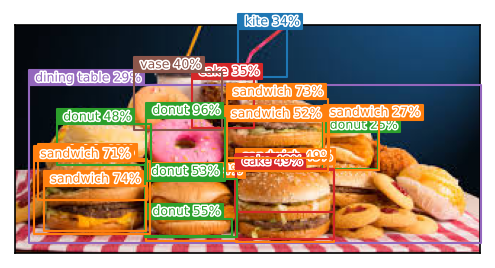


検出時間 : 3.843 秒
検出オブジェクト
 dog        95%  (   0,  10) - ( 225, 211)
 cat        87%  (   3,  12) - ( 219, 141)
 cat        84%  (   0,  18) - ( 225, 213)


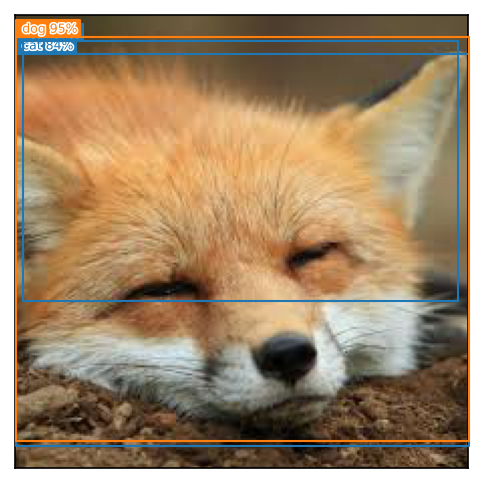


検出時間 : 3.806 秒
検出オブジェクト
 bear       99%  (  72,   0) - ( 385, 224)
 person     81%  (  67,   6) - ( 373, 221)
 cow        72%  (  12,   3) - ( 385, 174)
 bear       41%  ( 147,   0) - ( 379, 178)
 dog        35%  ( 147,   0) - ( 379, 178)
 cat        35%  (  72,  45) - ( 392, 223)
 bird       25%  (  55,  45) - ( 391, 224)


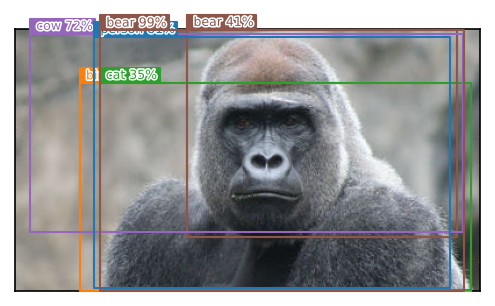


検出時間 : 3.783 秒
検出オブジェクト
 wine glass  88%  (   1,   0) - (  64, 103)
 cup        82%  (  69,  92) - ( 142, 161)
 orange     77%  ( 121,   0) - ( 187,  26)
 orange     70%  ( 220, 160) - ( 238, 171)
 orange     67%  ( 245, 142) - ( 262, 155)
 donut      63%  ( 196,  25) - ( 285, 112)
 person     60%  ( 251,  14) - ( 285,  47)
 hot dog    55%  ( 169,   2) - ( 229,  41)
 orange     39%  ( 101,   0) - ( 142,  25)
 sandwich   37%  ( 196,  15) - ( 287, 119)
 bowl       35%  ( 136,   0) - ( 237,  47)
 bottle     34%  ( 273,  29) - ( 285,  46)
 orange     33%  (  30,  25) - ( 148, 100)
 carrot     33%  ( 221, 112) - ( 243, 132)
 cake       30%  (   1, 103) - (  55, 129)
 wine glass  28%  (   1,   2) - (  64,  65)
 dining table  26%  (   2,   1) - ( 286, 152)
 donut      26%  (  33,  23) - ( 149, 100)


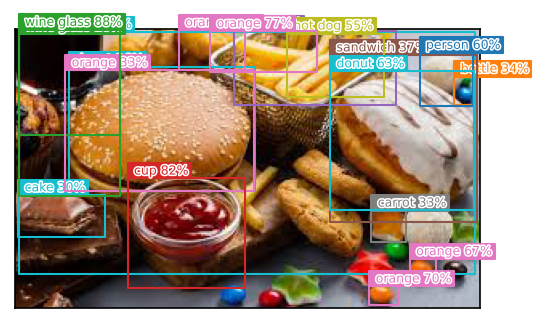


検出時間 : 3.786 秒
検出オブジェクト
 person    100%  (  69,   8) - ( 225, 204)
 tie        40%  (  76, 122) - ( 110, 202)


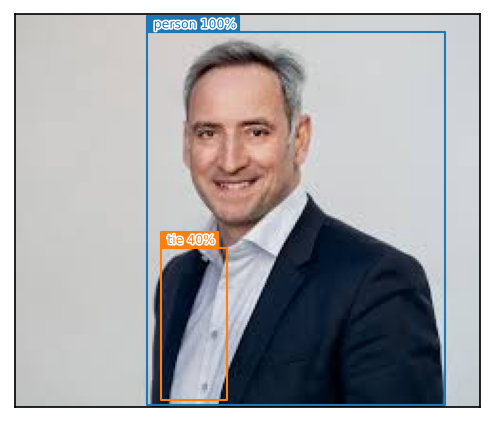


検出時間 : 3.753 秒
検出オブジェクト
 person    100%  ( 123,   7) - ( 251, 167)


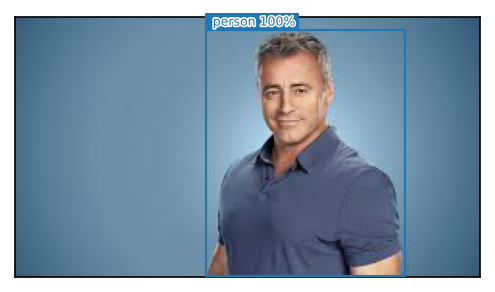


検出時間 : 3.771 秒
検出オブジェクト
 person    100%  ( 123,   7) - ( 272, 183)
 person    100%  (   2,   8) - ( 145, 182)
 tie        98%  (  83, 114) - ( 123, 182)
 person     82%  (  24,  21) - ( 258, 183)
 tie        32%  (  95, 101) - ( 126, 182)


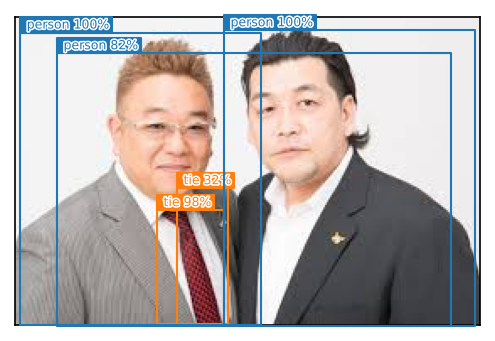


検出時間 : 3.787 秒
検出オブジェクト
 apple      91%  ( 141,  46) - ( 216, 123)
 apple      75%  (  54,  37) - ( 143, 152)
 apple      65%  (  56,  74) - ( 137, 149)
 apple      51%  (  55,  19) - ( 220, 161)
 apple      35%  (  69,  25) - ( 142,  86)


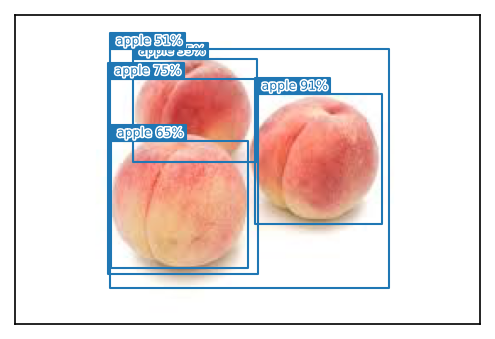


検出時間 : 3.908 秒
検出オブジェクト
 pizza      85%  (   5,   0) - ( 217, 151)
 pizza      73%  ( 110,   0) - ( 223, 148)
 pizza      73%  (   6,   1) - ( 138, 148)
 cup        71%  ( 240,  38) - ( 311, 150)
 pizza      59%  (  35,  39) - ( 132, 145)
 pizza      55%  (   0,   1) - ( 112, 108)
 dining table  42%  (   3,   8) - ( 299, 160)


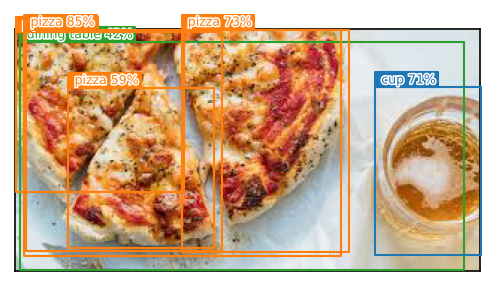


検出時間 : 3.816 秒
検出オブジェクト
 vase       91%  (  25,  63) - ( 137, 159)
 hot dog    64%  ( 154, 119) - ( 270, 158)
 bottle     58%  (  34,  26) - ( 135, 168)
 bottle     26%  ( 151,  31) - ( 261, 156)


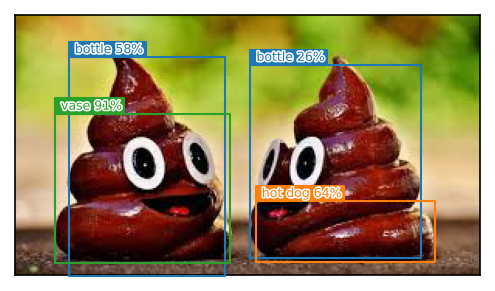


検出時間 : 3.808 秒
検出オブジェクト
 person    100%  (  74,   1) - ( 252, 182)


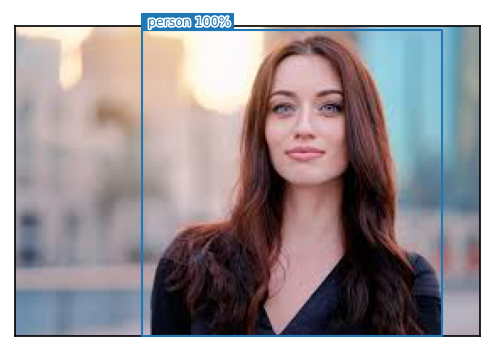

In [11]:
# 物体検出
from google.colab import files

print("\n物体検出したい画像を選択してください(複数選択可)")
uploaded = files.upload() # 分類したい画像を選択
  
for fn in uploaded.keys():
  run_detector(detector, fn)

